In [2]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import os

#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
maindir = "C:\\Users\\afajardo\\Desktop\\Projects\\Kaggle\\Zillow"

## Reading in the Data 

In [4]:
logerror = pd.read_csv(maindir + "\\data\\train_2016_v2.csv\\train_2016_v2.csv")
properties = pd.read_csv(maindir + "\\data\\properties_2016.csv\\properties_2016.csv")

# join on parcel id
data = pd.merge(properties,logerror[['parcelid','logerror']], on='parcelid')

C:\Users\afajardo\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Preprocessing

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# A custom transformer, which selects certain variables
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, desired_cols):
        self.desired_cols = desired_cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.desired_cols].values

# A custom transformer, which first selects the categorical variables
# from the DataFrame and then performs the dummification
class DF_Selector_GetDummies(BaseEstimator, TransformerMixin):
    def __init__(self, cat_dict):
        self.cat_dict = cat_dict
        self.ndummies = sum(len(c) - 1  for c in cat_dict.values()) 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.fillna(-1) # missing values are given -1 missing label
        foo = np.zeros((X.shape[0],self.ndummies))
        start = 0
        end = 0
        for c in sorted(self.cat_dict.keys()):
            end += len(self.cat_dict[c]) - 1
            foo[:, start:end] = pd.get_dummies(X[c].astype('category', categories=self.cat_dict[c]))[self.cat_dict[c][1:]]
            start += len(self.cat_dict[c]) - 1
        return foo

In [7]:
# Setup variables considered in the model

# numerical variables
num_atts = ['bathroomcnt','bedroomcnt','buildingqualitytypeid','calculatedbathnbr','finishedfloor1squarefeet',
           'calculatedfinishedsquarefeet','finishedsquarefeet12','finishedsquarefeet13',
           'finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6','fireplacecnt',
           'fullbathcnt','garagecarcnt','garagetotalsqft','latitude','longitude','lotsizesquarefeet',
           'poolcnt','poolsizesum','censustractandblock','roomcnt','threequarterbathnbr','unitcnt',
           'yardbuildingsqft17','yardbuildingsqft26','numberofstories',
            'structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount']

# categorical varaibles
cat_atts = ['airconditioningtypeid','architecturalstyletypeid',
           'buildingclasstypeid','heatingorsystemtypeid','pooltypeid10','pooltypeid2',
            'pooltypeid7','propertylandusetypeid','regionidcounty',
           'storytypeid','typeconstructiontypeid','yearbuilt','fireplaceflag',
           'taxdelinquencyflag']

# Dictionary of categorical variables and their default levels
cat_dict = {'airconditioningtypeid':[-1] + list(range(1,14)),
           'architecturalstyletypeid':[-1] + list(range(1,28)),
           'buildingclasstypeid':[-1] + list(range(1,6)),
            'heatingorsystemtypeid':[-1] + list(range(1,26)),
            'pooltypeid10': list(range(-1,2)),
            'pooltypeid2': list(range(-1,2)),
            'pooltypeid7': list(range(-1,2)),
            'propertylandusetypeid': [-1, 31,46,47,246,247,248,260,261,262,263,264,265,266,267,268,269,270,271,
                                     273,274,275,276,279,290,291],
            'regionidcounty': [2061,3101,1286],
            'storytypeid':[-1] + list(range(1,36)),
            'typeconstructiontypeid':[-1] + list(range(1,19)),
            'yearbuilt': [-1] + list(range(1885,2018)),
            'fireplaceflag': [-1] + ['True','False'],
            'taxdelinquencyflag': [-1] + ['Y','N']
           }

### Data Preprocessing Pipeline 

In [12]:
# Categorical pipeline
cat_pipeline = Pipeline([
        ('select_and_dummify', DF_Selector_GetDummies(cat_dict)),
        ('scaler', StandardScaler()),
    ])

# Numerical pipeline
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_atts)),
        ('imputer', Imputer())
    ])

# Full pipeline
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

## Training a Random Forest

In [8]:
from sklearn.model_selection import train_test_split

### Creating a training and test set

In [9]:
traindata, testdata = train_test_split(data, test_size = 0.2, random_state=9)
traindata = traindata.reset_index(drop=True)
testdata = testdata.reset_index(drop=True)

In [10]:
traindata.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror
0,11583759,NaN,NaN,NaN,2.0,2,NaN,4,2.0,NaN,...,NaN,148780,420949,2015,272169,5264.12,NaN,NaN,6.037702e+13,-0.0060
1,11186265,1,NaN,NaN,3.0,4,NaN,4,3.0,NaN,...,NaN,220496,275619,2015,55123,4784.18,NaN,NaN,6.037910e+13,0.0030
2,11267435,1,NaN,NaN,2.0,3,NaN,4,2.0,NaN,...,NaN,133199,177667,2015,44468,3055.39,NaN,NaN,6.037901e+13,0.3784
3,14481196,NaN,NaN,NaN,3.5,4,NaN,NaN,3.5,NaN,...,NaN,516586,1084952,2015,568366,11282.22,NaN,NaN,6.059032e+13,-0.1031
4,12159764,NaN,NaN,NaN,2.0,3,NaN,7,2.0,NaN,...,NaN,61716,139677,2015,77961,2057.55,NaN,NaN,6.037461e+13,0.1823


In [13]:
# Use preprocessing pipe line to prepare features data
train_feats = full_pipeline.fit_transform(traindata)
test_feats = full_pipeline.transform(testdata)

### Random Forests

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
regr_rf = RandomForestRegressor(n_estimators = 100, max_features = 5, random_state=2, max_depth=35)

In [16]:
regr_rf.fit(train_feats, traindata['logerror'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [17]:
# training RSq
regr_rf.score(train_feats, traindata['logerror'])

0.34977886346960918

### Test data Performance

In [51]:
absolute_error = abs(regr_rf.predict(test_feats) - testdata['logerror'])
testdata['absolute_error'] = absolute_error

In [19]:
absolute_error.describe()

count    18055.000000
mean         0.069382
std          0.152890
min          0.000009
25%          0.014262
50%          0.032632
75%          0.069716
max          4.606291
Name: logerror, dtype: float64

In [22]:
# querying absolute_errors that are less than the 75-th percentile
(absolute_error[absolute_error <= 0.069716]).describe()

count    13541.000000
mean         0.026007
std          0.018459
min          0.000009
25%          0.010529
50%          0.022543
75%          0.038996
max          0.069715
Name: logerror, dtype: float64

In [23]:
# querying absolute_errors that are greater than the 75-th percentile
(absolute_error[absolute_error > 0.069716]).describe()

count    4514.000000
mean        0.199496
std         0.264407
min         0.069716
25%         0.088848
50%         0.122683
75%         0.202633
max         4.606291
Name: logerror, dtype: float64

### Plotting the log-errors 

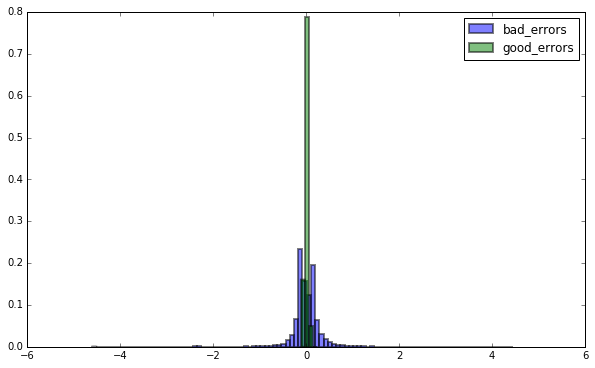

In [32]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='white')
ax.set_axis_bgcolor('white')
ax.hist(testdata[absolute_error > 0.069716]['logerror'].values, alpha=0.5, lw=2, weights = np.ones(4514) / 4514, bins = 100)
ax.hist(testdata[absolute_error <= 0.069716]['logerror'].values, alpha=0.5, lw=2, weights = np.ones(13541) / 13541,
       bins = 4)
plt.legend(['bad_errors','good_errors'])
plt.show()

### Plotting prediction vs actuals 

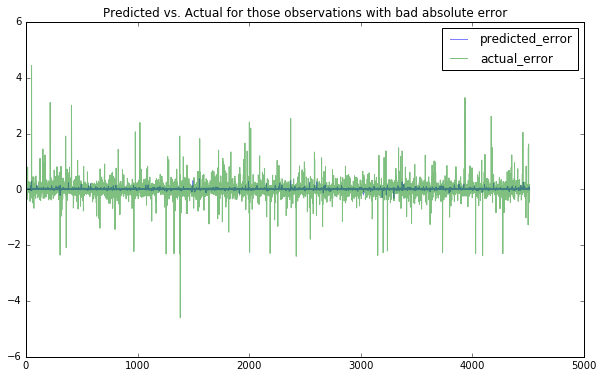

In [48]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='white')
ax.set_axis_bgcolor('white')
ax.plot(regr_rf.predict(test_feats)[np.where(absolute_error > 0.069716)], alpha=0.5)
ax.plot(testdata['logerror'].values[np.where(absolute_error > 0.069716)], alpha=0.5)
plt.legend(['predicted_error','actual_error'])
plt.title("Predicted vs. Actual for those observations with bad absolute error")

In [65]:
print("Summary descriptions of predictions")
print(Series(regr_rf.predict(test_feats)[np.where(absolute_error > 0.069716)]).describe())
print()
print("Summary descriptions of actual logerrors")
print(Series(testdata['logerror'].values[np.where(absolute_error > 0.069716)]).describe())

Summary descriptions of predictions
count    4514.000000
mean        0.013669
std         0.027927
min        -0.316973
25%         0.004799
50%         0.010870
75%         0.018949
max         0.379494
dtype: float64

Summary descriptions of actual logerrors
count    4514.000000
mean        0.013932
std         0.333141
min        -4.605000
25%        -0.109800
50%        -0.050200
75%         0.132800
max         4.445000
dtype: float64


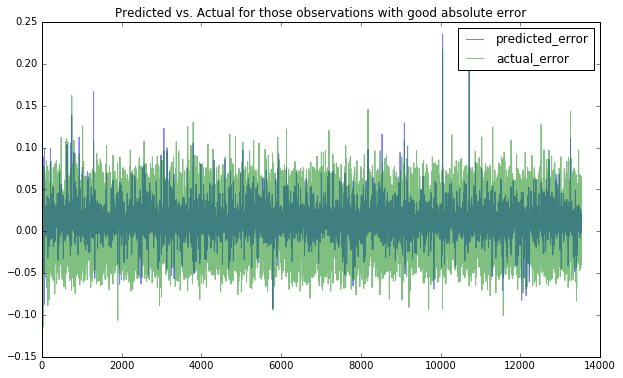

In [67]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='white')
ax.set_axis_bgcolor('white')
ax.plot(regr_rf.predict(test_feats)[np.where(absolute_error <= 0.069716)], alpha=0.5)
ax.plot(testdata['logerror'].values[np.where(absolute_error <= 0.069716)], alpha=0.5)
plt.legend(['predicted_error','actual_error'])
plt.title("Predicted vs. Actual for those observations with good absolute error")

In [66]:
print("Summary descriptions of predictions")
print(Series(regr_rf.predict(test_feats)[np.where(absolute_error <= 0.069716)]).describe())
print()
print("Summary descriptions of actual logerrors")
print(Series(testdata['logerror'].values[np.where(absolute_error <= 0.069716)]).describe())

Summary descriptions of predictions
count    13541.000000
mean         0.011616
std          0.012626
min         -0.092215
25%          0.006363
50%          0.010524
75%          0.015776
max          0.235712
dtype: float64

Summary descriptions of actual logerrors
count    13541.000000
mean         0.007717
std          0.032778
min         -0.114300
25%         -0.014100
50%          0.006000
75%          0.029600
max          0.242900
dtype: float64


## Things to consider

In [ ]:
# how to impute missing data? (currenly using mean values for numerical attributes)
# how to actually produce 6 predictions based on time
# interaction with counties?
# feature selection/engineering (i.e., transformations)
# whatsup with the 4514 observations in the test set... why are the log-errors so crazy
# whatsup with county 3101?